# Multi-label text classification using BERT

In [1]:
!pip install transformers

In [2]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn


In [3]:
# In Google Drive fine-tuning speed was increased by using NVIDIA A100-GPUs (40 GB)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Load Data and Prepare for BERT

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/Project 6/data"

In [6]:
# Load balanced dataset
#df_data = pd.read_pickle(data_dir + '/FINAL_faro_cleaned_embeddings_full.pkl')
df_data = pd.read_pickle(data_dir + '/FINAL_faro_cleaned_balanced.pkl')
df_data.head()

,Web-Text,Item-WebCmsId,Program-WebCmsId,ARBEIT.,BILDUNG.,ENERGIE.,FREIZEIT.,GESCHICHTE.,GESUNDHEIT.,GEWERBE.,...,SOZIALES.,STAAT UND POLITIK.,STRAFTAT.,TECHNIK.,UMWELT.,VERKEHR.,VOLKSKULTUR.,WIRTSCHAFT.,WISSENSCHAFT.,Categories
0,Kanton Neuenburg: Geld für Firmen die Arbeitsl...,EA6813CF-DD56-4DD0-87C6-73BC110095AA,A8613547-A3E2-4D81-91B8-7C5F3F2D5439,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Flüchtlinge sollen in der Schweiz arbeiten dür...,0A613907-A6DF-4861-9AFC-2EB288C03C32,ADAE6D37-23BB-4960-A51A-88EC2CD6D19B,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,Uber-Urteil zieht sich hin\nOb «Uber» ein Arbe...,5FCFADE8-EC82-4923-83E6-6ED1398C6E3D,87E2E34D-BF2E-4E02-A333-221C12F2D261,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,Probleme mit Billigcoiffeuren\nBilligcoiffeure...,9C7692CE-BB12-4124-9850-1240458CDD94,BF1F2044-73ED-472F-BEC3-A4118B3D977C,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Mindestlohninitiative soll Lohndruck ausgleich...,DD68BFAB-8119-4B26-A3B5-DC4F3C468340,713C4040-C93C-45EC-B810-08050E898100,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
df_data.shape

(32799, 30)

In [8]:
df_data[df_data["Web-Text"].isna()].shape

(0, 30)

In [9]:
df_data.columns[3:-1]

Index(['ARBEIT.', 'BILDUNG.', 'ENERGIE.', 'FREIZEIT.', 'GESCHICHTE.',
       'GESUNDHEIT.', 'GEWERBE.', 'INDUSTRIE.', 'JUSTIZ.', 'KULTUR.',
       'LANDWIRTSCHAFT.', 'MEDIEN UND KOMMUNIKATION.', 'MENSCH.', 'MILITÄR.',
       'PORTRÄT.', 'RELIGION.', 'SENSATION.', 'SOZIALES.',
       'STAAT UND POLITIK.', 'STRAFTAT.', 'TECHNIK.', 'UMWELT.', 'VERKEHR.',
       'VOLKSKULTUR.', 'WIRTSCHAFT.', 'WISSENSCHAFT.'],
      dtype='object')

In [10]:
label_names = [
    'ARBEIT.', 'BILDUNG.', 'ENERGIE.', 'FREIZEIT.', 'GESCHICHTE.',
    'GESUNDHEIT.', 'GEWERBE.', 'INDUSTRIE.', 'JUSTIZ.', 'KULTUR.',
    'LANDWIRTSCHAFT.', 'MEDIEN UND KOMMUNIKATION.', 'MENSCH.', 'MILITÄR.',
    'PORTRÄT.', 'RELIGION.', 'SENSATION.', 'SOZIALES.',
    'STAAT UND POLITIK.', 'STRAFTAT.', 'TECHNIK.', 'UMWELT.', 'VERKEHR.',
    'VOLKSKULTUR.', 'WIRTSCHAFT.', 'WISSENSCHAFT.'
]

In [11]:
# Filter relevant features
relevant_cols = ['Web-Text'] + label_names

In [12]:
# Create new BERT dataframe
df_bert = df_data[relevant_cols]

In [13]:
df_bert.head()

,Web-Text,ARBEIT.,BILDUNG.,ENERGIE.,FREIZEIT.,GESCHICHTE.,GESUNDHEIT.,GEWERBE.,INDUSTRIE.,JUSTIZ.,...,SENSATION.,SOZIALES.,STAAT UND POLITIK.,STRAFTAT.,TECHNIK.,UMWELT.,VERKEHR.,VOLKSKULTUR.,WIRTSCHAFT.,WISSENSCHAFT.
0,Kanton Neuenburg: Geld für Firmen die Arbeitsl...,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Flüchtlinge sollen in der Schweiz arbeiten dür...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Uber-Urteil zieht sich hin\nOb «Uber» ein Arbe...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Probleme mit Billigcoiffeuren\nBilligcoiffeure...,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mindestlohninitiative soll Lohndruck ausgleich...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splits for Train, Test and Validation

In [14]:
from sklearn.model_selection import train_test_split
# # split into train and test
# df_train, df_test = train_test_split(df_bert, random_state=77, test_size=0.30, shuffle=True)
# # split test into test and validation datasets
# df_test, df_valid = train_test_split(df_bert, random_state=88, test_size=0.50, shuffle=True)

# First split: Separate out the test set
df_train, df_test = train_test_split(df_bert, test_size=0.4, random_state=42, shuffle=True)

# Second split: Separate the remaining data into training and validation sets
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42, shuffle=True)

In [15]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (19679, 27), Test: (6560, 27), Valid: (6560, 27)


### Test BERTs WordPiece Tokenizer

The tokenizer is responsible for dividing the sequence into tokens that match entries in the tokenizer's vocabulary. These tokens can be either whole words or subwords. Subsequently, these tokens are transformed into IDs that the model can interpret. The tokenizer provides a dictionary containing all the parameters required for its corresponding model to function correctly. Additionally, the tokenizer automatically includes "special tokens" (if the associated model requires them), which are specific IDs the model occasionally utilizes.

https://huggingface.co/docs/transformers/glossary#input-ids

In [16]:
from transformers import BertTokenizer, BertModel

In [17]:
# Load pretrained BERT tokenizer (in order to test it)
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [18]:
# Find longest Web-text string
df_bert[df_bert['Web-Text'].str.len() == max(df_bert['Web-Text'].str.len())]['Web-Text'].values[0]

'Vollkorn - gesundheitsfördernd, aber nicht beliebt\nVollkorn-Getreide dient den Menschen seit Jahrtausenden als Grundnahrungsmittel. Die Getreidekörner wurden üblicherweise ganz verzehrt oder zu Brei vermahlen und zu Fladenbrot verarbeitet. Der Keim und vor allem die Schale (Kleie) enthalten eine Reihe wichtiger Ballaststoffe, Vitamine, Öle und Mineralstoffe. Auf die gesundheitsfördernden Substanzen von Vollkorn wurde in vielen Studien hingewiesen. Brot aus gesiebtem Weissmehl galt schon früh als Statussymbol der Oberschicht. Das konnten sich aber nur wenige leisten. Vollkorn wurde dann im Zuge der Industrialisierung vom veredelten - «raffinierten» - Weissmehl verdrängt. Dank moderner Müllerei- und Verarbeitungsmethoden war es möglich, das Korn von der Schale und dem Keim in grossem Stil zu trennen. Somit wurde Weissmehl einer grösseren Bevölkerungsschicht zugänglich. Weissmehl ist besonders beliebt, da es Backwaren eine weichere Textur verleiht. Der Teig aus feinem Mehl ist besser fo

In [19]:
# Test the BERT tokenizer, which is a WordPiece tokenizer with longest string
test_text = df_bert[df_bert['Web-Text'].str.len() == max(df_bert['Web-Text'].str.len())]['Web-Text'].values[0]
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  102,  1340, 23330,   223,  4376, 14658, 30944,   806,   401,   237,
         11025,  1340, 23330,   223,  9905,  6497,   179,  1012,   617, 26972,
           106,   250,   854,   583,  9430,  5666, 15959, 30947,   552,   125,
          9905, 23330,   105,   595, 25390,  8768,   835,  2894,  6849,   360,
           167,  3028,  1451,   419,   106,   143,   167,  6945,   166,   103]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [20]:
# Check for max len
len(encodings['input_ids'][0])

50

In [23]:
# If we decode the previous sequence of ids we get:
decoded_sequence = tokenizer.decode(encodings['input_ids'][0])
decoded_sequence

'[CLS] vollkorn - gesundheitsfordernd, aber nicht beliebt vollkorn - getreide dient den menschen seit jahrtausenden als grundnahrungsmittel. die getreidekorner wurden ublicherweise ganz verzehrt oder zu brei vermahlen und zu fladen [SEP]'

### Define Hyperparameter Values

In [24]:
# The number of unique labels or classes in the dataset.
LABEL_COUNT = len(label_names)
# The maximum sequence length for tokenized input data.
MAX_LEN = 256
# The number of samples per batch during training, validation and testing.
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
# The number of complete passes through the training dataset.
EPOCHS = 12 #10
# The step size used by the optimizer to update model parameters.
LEARNING_RATE = 1e-05
# The decision threshold for classification, particularly for sigmoid outputs.
THRESHOLD = 0.5 # threshold for the sigmoid

In [25]:
# Combine Outputs (level-1 SDES descriptors) to List
target_list = list(df_bert.columns)
target_list = target_list[1:]
target_list

['ARBEIT.',
 'BILDUNG.',
 'ENERGIE.',
 'FREIZEIT.',
 'GESCHICHTE.',
 'GESUNDHEIT.',
 'GEWERBE.',
 'INDUSTRIE.',
 'JUSTIZ.',
 'KULTUR.',
 'LANDWIRTSCHAFT.',
 'MEDIEN UND KOMMUNIKATION.',
 'MENSCH.',
 'MILITÄR.',
 'PORTRÄT.',
 'RELIGION.',
 'SENSATION.',
 'SOZIALES.',
 'STAAT UND POLITIK.',
 'STRAFTAT.',
 'TECHNIK.',
 'UMWELT.',
 'VERKEHR.',
 'VOLKSKULTUR.',
 'WIRTSCHAFT.',
 'WISSENSCHAFT.']

### Create Custom Pytorch Dataset Class

The CustomDataset class is a custom implementation of a dataset for use with PyTorch's data loading utilities. It inherits from torch.utils.data.Dataset, which is an abstract class representing a dataset. This custom dataset class is designed to handle the preprocessing and tokenization of text data and prepare it for training, validation, or testing a machine learning model.

In [26]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer  # Tokenizer to convert text into tokens
        self.df = df  # DataFrame containing the dataset
        self.title = list(df['Web-Text'])  # List of text data from the DataFrame
        self.targets = self.df[target_list].values  # Target values for each text entry
        self.max_len = max_len  # Maximum length for tokenized sequences

    def __len__(self):
        return len(self.title)  # Returns the total number of samples in the dataset

    def __getitem__(self, index):
        title = str(self.title[index])  # Get the text at the specified index
        title = " ".join(title.split())  # Clean up the text by removing extra spaces
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,  # Add special tokens for the model
            max_length=self.max_len,  # Pad or truncate the text to the maximum length
            padding='max_length',  # Pad sequences to the maximum length
            return_token_type_ids=True,  # Include token type IDs in the output
            truncation=True,  # Truncate sequences longer than the maximum length
            return_attention_mask=True,  # Include attention mask in the output
            return_tensors='pt'  # Return PyTorch tensors
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),  # Token IDs tensor
            'attention_mask': inputs['attention_mask'].flatten(),  # Attention mask tensor
            'token_type_ids': inputs["token_type_ids"].flatten(),  # Token type IDs tensor
            'targets': torch.FloatTensor(self.targets[index]),  # Target values tensor
            'title': title  # Original text
        }

### Generate Test, Validation and Train Torch Dataset

In [27]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [28]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  102,   125,  1784,   210,  3432, 30941,   127,  4962,  3942,   223,
         14046,  5418, 19116,   207,   327,  6252,   552,   237,   193,   232,
         22109,  1655,   806,  1385,   142,   343,  5236,   210, 26446,   479,
          5809,   142, 24928,   728,   552,   125,  5236, 25582,   173,  2453,
          3432,  1642,   552,  1682,   739,   207, 15681,  6084,  3394,   806,
           347,   228,   704,   237,   417,  3432,   367,   316,   552,  1479,
          2663,   281,  5418, 19116, 20197,   106,   167,   179, 12100, 30938,
           142,   577,   739,   552,   103,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

### Create DataLoader Objects
The DataLoader in PyTorch is a utility that abstracts the complexity of fetching and batching data. It provides an iterable over a dataset and handles tasks such as shuffling, batching, and parallel data loading using multiple workers.

In [29]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [30]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # Load a pre-trained BERT model for German language
        self.bert_model = BertModel.from_pretrained('dbmdz/bert-base-german-uncased', return_dict=True)
        # Dropout layer to prevent overfitting
        # This means that during training, 30% of the neurons' outputs will be randomly set to zero.
        self.dropout = torch.nn.Dropout(0.3)
        # Linear layer for classification, mapping BERT output to the number of labels
        self.linear = torch.nn.Linear(768, LABEL_COUNT)

    def forward(self, input_ids, attn_mask, token_type_ids):
        # Get the BERT model output using the input IDs, attention mask, and token type IDs
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        # Apply dropout to the pooled output from BERT
        output_dropout = self.dropout(output.pooler_output)
        # Pass the dropout output through the linear layer for classification
        output = self.linear(output_dropout)
        return output # Return the final output

model = BERTClass() # Instantiate the BERTClass model

# Move the model to the specified device (GPU A100)
model.to(device)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [31]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [33]:
#from transformers import AdamW
import torch.optim as optim

# AdamW is a widely used optimization algorithm that combines the advantages of
# adaptive learning rates with effective weight decay regularization, making it
# a robust choice for training deep learning models.
# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-5)

# Training and Validation Loops

### Accuracy Calculation:
The accuracy is computed by comparing the model's predictions to the true target values and then calculating the proportion of correct predictions.

- The model outputs are passed through a sigmoid function to convert them to probabilities between 0 and 1.
- The probabilities are rounded to 0 or 1 based on a threshold of 0.5. This converts the probabilities to binary predictions.
- Both the predictions and the targets are moved to the CPU and converted to numpy arrays for easier manipulation.
- The predictions are compared to the targets to count the number of correct predictions.


The total number of correct predictions is divided by the total number of samples to compute the accuracy.

In [34]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [35]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [36]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    torch.save(model.state_dict(), os.path.join(data_dir,"output",f"FINAL_MLTC_BERT_model_state_{str(epoch)}.bin"))

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","FINAL_MLTC_BERT_model_state_best.bin"))
        best_accuracy = val_acc

Epoch 1/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.3142, val_loss=0.2335 train_acc=0.9054, val_acc=0.9244
Epoch 2/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.2143, val_loss=0.1853 train_acc=0.9289, val_acc=0.9375
Epoch 3/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1791, val_loss=0.1630 train_acc=0.9397, val_acc=0.9446
Epoch 4/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1580, val_loss=0.1507 train_acc=0.9477, val_acc=0.9488
Epoch 5/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1426, val_loss=0.1431 train_acc=0.9535, val_acc=0.9517
Epoch 6/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1298, val_loss=0.1382 train_acc=0.9583, val_acc=0.9525
Epoch 7/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1192, val_loss=0.1353 train_acc=0.9622, val_acc=0.9536
Epoch 8/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1095, val_loss=0.1345 train_acc=0.9659, val_acc=0.9536
Epoch 9/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.1005, val_loss=0.1332 train_acc=0.9692, val_acc=0.9538
Epoch 10/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.0923, val_loss=0.1345 train_acc=0.9723, val_acc=0.9538
Epoch 11/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.0845, val_loss=0.1351 train_acc=0.9751, val_acc=0.9534
Epoch 12/12


  0%|          | 0/308 [00:00<?, ?it/s]

train_loss=0.0778, val_loss=0.1357 train_acc=0.9775, val_acc=0.9538


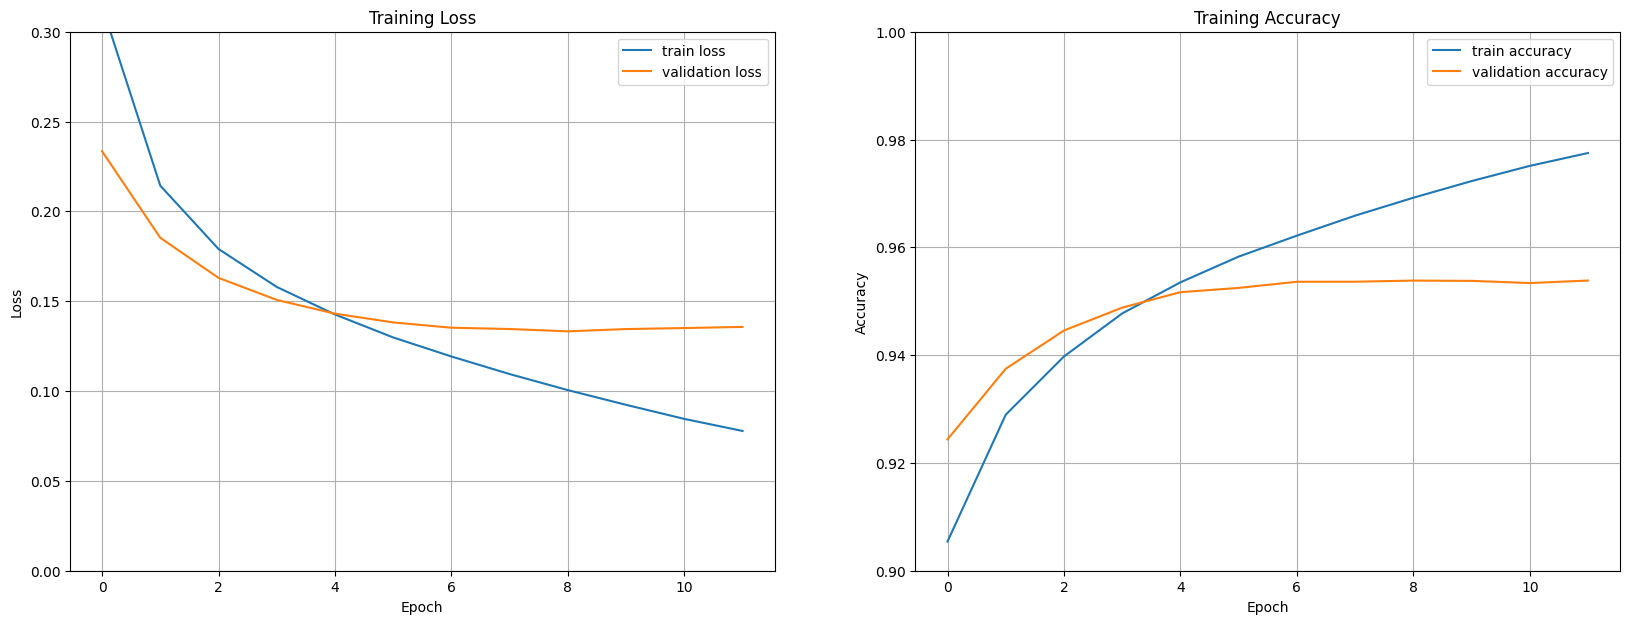

In [37]:
import matplotlib.pyplot as plt
# Set up the figure size
plt.rcParams["figure.figsize"] = (20, 7)  # Width is doubled for two plots

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2)

# Plot on the first subplot
axs[0].plot(history['train_loss'], label='train loss')
axs[0].plot(history['val_loss'], label='validation loss')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()
axs[0].set_ylim([0, 0.3])
axs[0].grid()

# Plot on the second subplot (duplicate of the first)
axs[1].plot(history['train_acc'], label='train accuracy')
axs[1].plot(history['val_acc'], label='validation accuracy')
axs[1].set_title('Training Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].set_ylim([0.9, 1])
axs[1].grid()

# Display the plot
plt.show()

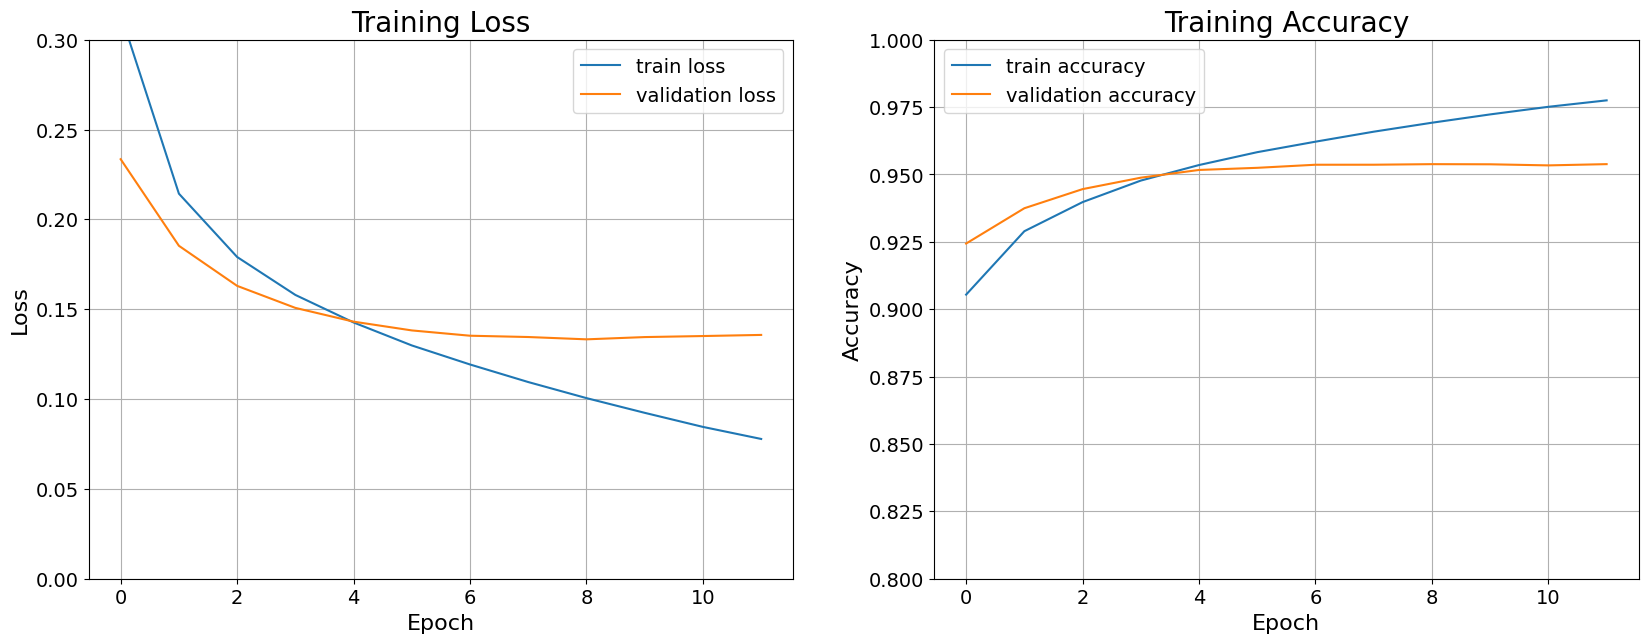

In [38]:
# Set up the figure size
plt.rcParams["figure.figsize"] = (20, 7)  # Width is doubled for two plots

# Common text size for all plots
title_size = 20
label_size = 16
legend_size = 14
tick_size = 14

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2)

# Plot on the first subplot
axs[0].plot(history['train_loss'], label='train loss')
axs[0].plot(history['val_loss'], label='validation loss')
axs[0].set_title('Training Loss', fontsize=title_size)
axs[0].set_ylabel('Loss', fontsize=label_size)
axs[0].set_xlabel('Epoch', fontsize=label_size)
axs[0].legend(fontsize=legend_size)
axs[0].set_ylim([0, 0.3])
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=tick_size)

# Plot on the second subplot (duplicate of the first)
axs[1].plot(history['train_acc'], label='train accuracy')
axs[1].plot(history['val_acc'], label='validation accuracy')
axs[1].set_title('Training Accuracy', fontsize=title_size)
axs[1].set_ylabel('Accuracy', fontsize=label_size)
axs[1].set_xlabel('Epoch', fontsize=label_size)
axs[1].legend(fontsize=legend_size)
axs[1].set_ylim([0.8, 1])
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)

# Display the plot
plt.show()

The training and validation losses start high but steadily decrease, converging around epoch 10-11, indicating effective learning and minimal further improvement needed. Both training and validation accuracies increase over time, reaching high values (around 0.98-0.99) by the end of training, suggesting good model performance. Validation accuracy surpasses training accuracy for a few epochs, indicating good generalization and low risk of overfitting. Overall, the BERT model demonstrates successful training and strong performance on both training and validation sets.

## Evaluation of the model

### CPU to slow

In [39]:
model_name_ = "FINAL_MLTC_BERT_model_state_3.bin"

In [40]:
# Loading pretrained model (best model)
model_test = BERTClass()
model_test.load_state_dict(torch.load(os.path.join(data_dir,"output",model_name_), map_location=torch.device('cpu')))
model_test = model_test.to(device)

In [41]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model_test, optimizer)

In [42]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.9434451219512195

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [45]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [46]:
def hamming_accuracy(actuals, predictions):
    return (actuals == predictions).mean()

# Assuming actuals and predictions are numpy arrays of shape (n_samples, 27)
hamming_acc = hamming_accuracy(np.array(target_values), np.array(predictions))
print(f"Hamming Accuracy: {hamming_acc * 100:.2f}%")

Hamming Accuracy: 95.15%


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Example to convert your list of arrays into a single matrix
actuals_matrix = np.vstack(target_values)  # Do the same for predictions if necessary

# Assuming 'predictions' is already in a similar format or adjust accordingly
predictions_matrix = np.vstack(predictions)

print("Label-Accuracy:")
for i in range(actuals_matrix.shape[1]):  # Assuming actuals and predictions are numpy arrays
    label_accuracy = accuracy_score(actuals_matrix[:, i], predictions_matrix[:, i])

    print(f'{label_names[i]}: {round(label_accuracy, 3)}')

Label-Accuracy:
ARBEIT.: 0.96
BILDUNG.: 0.975
ENERGIE.: 0.982
FREIZEIT.: 0.959
GESCHICHTE.: 0.973
GESUNDHEIT.: 0.957
GEWERBE.: 0.944
INDUSTRIE.: 0.963
JUSTIZ.: 0.946
KULTUR.: 0.935
LANDWIRTSCHAFT.: 0.974
MEDIEN UND KOMMUNIKATION.: 0.949
MENSCH.: 0.91
MILITÄR.: 0.976
PORTRÄT.: 0.918
RELIGION.: 0.979
SENSATION.: 0.943
SOZIALES.: 0.934
STAAT UND POLITIK.: 0.885
STRAFTAT.: 0.946
TECHNIK.: 0.966
UMWELT.: 0.94
VERKEHR.: 0.964
VOLKSKULTUR.: 0.976
WIRTSCHAFT.: 0.927
WISSENSCHAFT.: 0.957


In [54]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:6560 
predictions:torch.Size([6560, 26]) 
prediction_probs:torch.Size([6560, 26]) 
target_values:torch.Size([6560, 26])


In [55]:
print(classification_report(target_values, predictions, target_names=target_list))

                           precision    recall  f1-score   support

                  ARBEIT.       0.71      0.51      0.59       376
                 BILDUNG.       0.81      0.66      0.72       323
                 ENERGIE.       0.89      0.74      0.81       334
                FREIZEIT.       0.75      0.58      0.66       433
              GESCHICHTE.       0.75      0.57      0.65       283
              GESUNDHEIT.       0.84      0.72      0.77       679
                 GEWERBE.       0.71      0.52      0.60       534
               INDUSTRIE.       0.68      0.58      0.62       349
                  JUSTIZ.       0.71      0.52      0.60       518
                  KULTUR.       0.75      0.66      0.70       760
          LANDWIRTSCHAFT.       0.81      0.69      0.75       366
MEDIEN UND KOMMUNIKATION.       0.69      0.54      0.61       481
                  MENSCH.       0.69      0.45      0.55       786
                 MILITÄR.       0.79      0.73      0.76     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
titles[:10]

['Mia (19): «Ohne Speed kam ich nicht mehr aus dem Bett» Mia kämpft mit Drogen, ihrem Gewicht und ihrem Selbstwertgefühl. Seit ihr Vater die Familie verlassen hat, weil sich dieser in seine Sekretärin verliebt hatte, fühlt sich Mia verloren. Wir geben ihr eine Stimme.',
 'Das Stockhus brennt! – Der Zürcher Phönix aus der Glarner Asche Auf einmal stand sein Traum in Flammen. Eine Wohlfühloase hatte der Zürcher Christian Drescher aus dem Berggasthof Fronalpstock in den Glarner Alpen machen wollen. Und das durfte auch etwas kosten. Doch am 9. November 2019 brannte das Gasthaus oberhalb von Mollis vollständig nieder.',
 'Bundespräsident will Nachverhandlungen mit der EU Kurz nach Amtsantritt als Bundespräsident sorgt Ueli Maurer schon für Aufsehen. Gegenüber «Tele Züri» meinte er, dass es beim Dossier «Rahmenabkommen» Nachverhandlungen mit der EU brauche.',
 'Nachrichten GR: 1 Million Franken Unwetter-Schäden in Scuol AG: Kollision zwischen SBB-Regionalzug und Auto',
 'SRF Börse vom 09.02.

In [49]:
# pd.concat([pd.DataFrame(titles),
#            pd.DataFrame(target_values),
#            pd.DataFrame(predictions),
#            pd.DataFrame(prediction_probs)], axis=1).to_csv(data_dir + '/Web_predictions.csv')

In [50]:
target_values[:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

In [51]:
predictions[:10]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

In [52]:
prediction_probs[:10]

tensor([[0.0088, 0.0451, 0.0041, 0.0292, 0.0165, 0.9686, 0.0177, 0.0168, 0.0092,
         0.0581, 0.0089, 0.0282, 0.6490, 0.0121, 0.0329, 0.0331, 0.0091, 0.0093,
         0.0092, 0.3118, 0.0162, 0.0045, 0.0126, 0.0062, 0.0125, 0.1029],
        [0.0033, 0.0081, 0.0140, 0.0169, 0.0061, 0.0152, 0.4828, 0.0065, 0.0151,
         0.0235, 0.0043, 0.0109, 0.0146, 0.0130, 0.0135, 0.0029, 0.9648, 0.0177,
         0.0084, 0.0127, 0.0076, 0.0491, 0.0055, 0.0099, 0.0214, 0.0084],
        [0.0055, 0.0024, 0.0042, 0.0046, 0.0078, 0.0066, 0.0055, 0.0028, 0.0146,
         0.0189, 0.0031, 0.0046, 0.0082, 0.0137, 0.0370, 0.0036, 0.0081, 0.0166,
         0.9816, 0.0067, 0.0042, 0.0067, 0.0028, 0.0114, 0.0085, 0.0052],
        [0.0063, 0.0051, 0.0192, 0.0086, 0.0045, 0.0106, 0.0109, 0.0193, 0.0140,
         0.0210, 0.0079, 0.0070, 0.0028, 0.0085, 0.0099, 0.0027, 0.8149, 0.0348,
         0.0082, 0.0048, 0.0068, 0.7194, 0.2409, 0.0115, 0.0372, 0.0098],
        [0.0114, 0.0054, 0.0080, 0.0136, 0.0083, 0.9051,

In [56]:
# sanity check
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

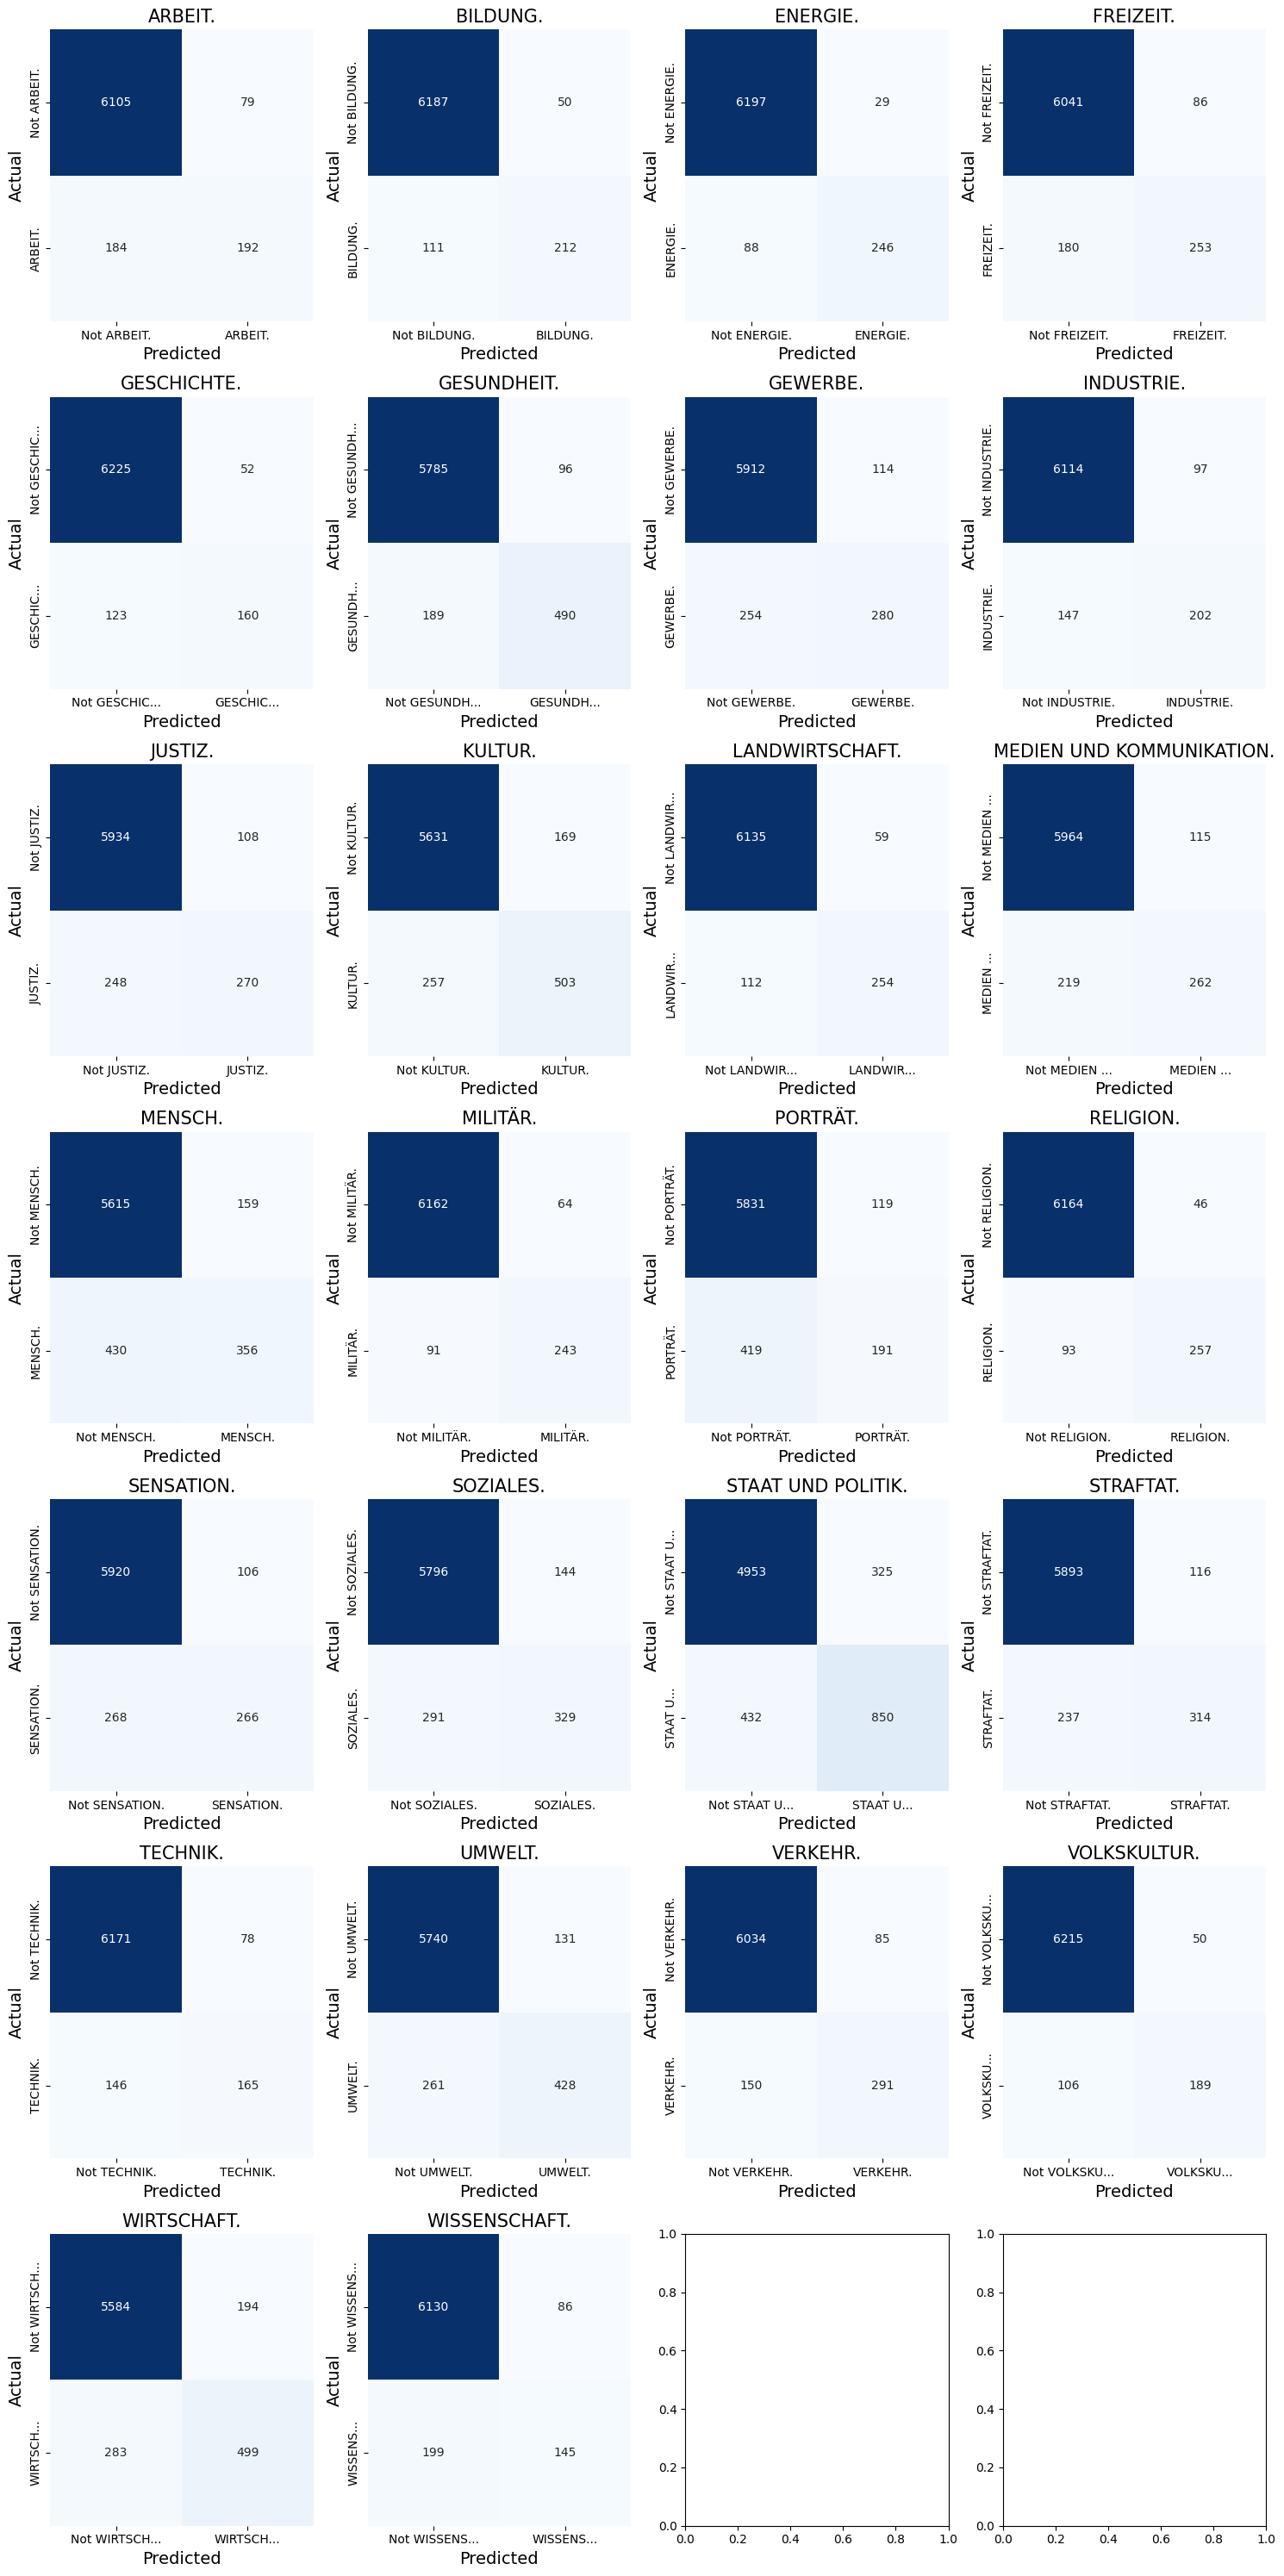

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title, fontsize=15)
    ax.set_ylabel('Actual', fontsize=14)
    ax.set_xlabel('Predicted', fontsize=14)

# Set up the figure and subplots
fig, axs = plt.subplots(7, 4, figsize=(15, 30))
#fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Compute and plot confusion matrix for each label
for i, label in enumerate(label_names[:26]):  # Ensure only 26 labels are processed for the 13x2 grid
    row, col = divmod(i, 4)
    try:
        cm = confusion_matrix(target_values[:, i], predictions[:, i])
        if len(label)<=10:
            plot_confusion_matrix(axs[row, col], cm, labels=[f'Not {label}', f'{label}'], title=label)
        else:
            plot_confusion_matrix(axs[row, col], cm, labels=[f'Not {label[0:7]}...', f'{label[0:7]}...'], title=label)
    except:
        next
# Adjust layout and save the figure to a file
plt.tight_layout()
plt.savefig(data_dir + "/BERT_Confusion_Matrix.png")
plt.show()

## Predicting on raw text

In [60]:
import requests


class ArticleTagger():
  """
  Class to test predictive power of the model to new data
  Input:
  - BERT Model Path
  - Play SRF video IDs
  OR
  - SRF Article IDs

  Output:
  - Predictet Tag
  """
  def __init__(self, model_name, target_list, article_id_list=None, video_id_list=None):
    if article_id_list is None and video_id_list is None:
      raise ValueError("Either 'article_id' or 'video_id' must be provided.")
    self.df_articles = pd.DataFrame({'article_id':article_id_list}, index=range(len(article_id_list)))
    self.df_videos = pd.DataFrame({'article_id':video_id_list}, index=range(len(article_id_list)))
    self.model = BERTClass()
    self.model.load_state_dict(
        torch.load(
            os.path.join(
                data_dir, "output", model_name
                ),
            map_location=torch.device('cpu')
          )
        )
    self.model = self.model.to(device)

  @staticmethod
  def fetch_article_info(article_id):
    try:
        response = requests.get(f'https://www.srf.ch/article/{article_id}/json')
        response.raise_for_status()  # Raise an HTTPError for bad responses
        json_data = response.json()
        lead = json_data['info']['lead']
        title = json_data['info']['title']
        try:
          shortLead = json_data['info']['shortLead']
          return title, shortLead
        except:
          return title, lead
    except requests.RequestException as e:
        print(f"Error fetching data for article_id {article_id}: {e}")
        return None, None


  def process_articles(self):
    self.df_articles['article_urls'] = self.df_articles['article_id'].apply(lambda x: f'https://www.srf.ch/article/{x}')
    self.df_articles[['json_title', 'json_lead']] = self.df_articles['article_id'].apply(
        lambda x: pd.Series(self.fetch_article_info(x))
    )
    self.df_articles['raw_text'] = self.df_articles['json_title'] + '. ' + self.df_articles['json_lead']
    self.df_articles = self.df_articles.drop(columns=['json_title', 'json_lead'])
    return self.df_articles

  def bert_tokenizer(self, raw_text):
    # Load pretrained BERT tokenizer (in order to test it)
    tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')
    return tokenizer.encode_plus(
      raw_text,
      truncation=True,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=True,
      padding='longest',
      return_attention_mask=True,
      return_tensors='pt',
    )

  def bert_predictor(self):
    for i, row in self.df_articles.iterrows():
      encoded_text = self.bert_tokenizer(row['raw_text'])
      input_ids = encoded_text['input_ids'].to(device)
      attention_mask = encoded_text['attention_mask'].to(device)
      token_type_ids = encoded_text['token_type_ids'].to(device)
      output = model(input_ids, attention_mask, token_type_ids)
      # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
      output = torch.sigmoid(output).detach().cpu()
      # thresholding at 0.5
      output = output.flatten().round().numpy()

      # Correctly identified the topic of the paper: High energy physics
      result_tag_list = []
      for idx, p in enumerate(output):
        if p==1:
          result_tag_list.append(target_list[idx])

      self.df_articles.loc[i, 'predictions'] = str(result_tag_list)
    return self.df_articles



In [61]:
test = ArticleTagger("FINAL_MLTC_BERT_model_state_9.bin", target_list, ['324363142', '20879572', '483208222', '414094172', '451438338', '212750780', '484955577'])
test.process_articles()
test.bert_predictor()

,article_id,article_urls,raw_text,predictions
0,324363142,https://www.srf.ch/article/324363142,Vom Geliebten in die Prostitution gedrängt. «L...,"['MENSCH.', 'STRAFTAT.']"
1,20879572,https://www.srf.ch/article/20879572,Ukraine will versprochene Kampfjets im Frühlin...,"['MILITÄR.', 'STAAT UND POLITIK.']"
2,483208222,https://www.srf.ch/article/483208222,Im Tessin schüttet es wie aus Kübeln. Im Süden...,['UMWELT.']
3,414094172,https://www.srf.ch/article/414094172,Ousman Sonko wird zu 20 Jahren Freiheitsstrafe...,['JUSTIZ.']
4,451438338,https://www.srf.ch/article/451438338,Apple ID ohne Vorwarnung für immer gesperrt. Z...,"['JUSTIZ.', 'TECHNIK.']"
5,212750780,https://www.srf.ch/article/212750780,Grosse Lohnunterschiede zwischen Berg- und Tal...,['ARBEIT.']
6,484955577,https://www.srf.ch/article/484955577,"Sie schrieb, wenn die Kinder schliefen – und h...","['KULTUR.', 'MEDIEN UND KOMMUNIKATION.', 'SENS..."


### Possible Future Add-On: Upgraded Hierarchical Model?

To upgrade the `BERTClass` for hierarchical multi-label classification, you need to make a few changes. In hierarchical multi-label classification, each instance can belong to multiple classes, and these classes are organized in a hierarchy. The model's output layer should reflect the hierarchy of the labels.

Here's an example of how you might adjust the class for hierarchical multi-label classification:

1. **Modify the Linear Layer to Match the Number of Labels:**
   You need to change the output dimension of the linear layer to match the total number of labels in your hierarchy.

2. **Use an Appropriate Activation Function:**
   For multi-label classification, you typically use a sigmoid activation function at the output layer because each label is treated as an independent Bernoulli distribution.

3. **Loss Function:**
   You should use a loss function that is suitable for multi-label classification, such as binary cross-entropy loss.

4. **Output Representation:**
   The model should output probabilities for each label, rather than just a single class.

Here is an example of how your model class might be modified:




Remember to pass the total number of labels in your hierarchical structure when initializing the model. The `forward` function now applies a sigmoid activation function to the output of the linear layer, which will return a probability distribution across all labels for each instance.

In your training loop, you would also need to ensure that your targets are represented as a binary multi-hot encoded vector, where each label is either 0 or 1, and use an appropriate loss function, like the Binary Cross-Entropy loss (`torch.nn.BCELoss`), which is suitable for multi-label classification tasks.

In [ ]:

import torch
from transformers import BertModel
import torch.nn.functional as F

class BERTHierarchicalMultiLabel(torch.nn.Module):
    def __init__(self, total_labels):
        super(BERTHierarchicalMultiLabel, self).__init__()
        self.bert_model = BertModel.from_pretrained('dbmdz/bert-base-german-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        # Update the number of labels to the total number in your hierarchy
        self.linear = torch.nn.Linear(768, total_labels)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        # Apply the linear layer and then a sigmoid activation function
        logits = self.linear(output_dropout)
        # Sigmoid activation to get multi-label probabilities
        probs = torch.sigmoid(logits)
        return probs

# Example usage:
# Let's say you have 20 labels in your hierarchy
total_labels = 20
model = BERTHierarchicalMultiLabel(total_labels)



In [ ]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

To actually enforce the hierarchical structure, you would need to post-process the predictions. Here's a simplistic example of how you might enforce a hierarchy post-prediction (note that this is just a conceptual example and would need to be adapted to your specific hierarchy):

In the above enforce_hierarchy function, hierarchy should be a dictionary where keys are indices of child labels and values are indices of their respective parent labels. After you generate predictions using your model, you would call enforce_hierarchy to adjust the predictions to respect the hierarchy.

Remember that in a real-world application, enforcing a hierarchy can be complex and might require a more sophisticated approach than the simple example provided. You might need to implement a custom training routine that considers the hierarchical structure of the labels during the learning process, which could involve modifying both the loss function and the way predictions are made.

In [ ]:
def enforce_hierarchy(predictions, hierarchy):
    """
    Enforce the hierarchical structure on the predictions.

    :param predictions: A tensor of predictions.
    :param hierarchy: A dictionary representing the parent-child relationships.
    :return: The adjusted predictions.
    """
    # Convert predictions to probabilities
    probabilities = torch.sigmoid(predictions)

    # Threshold probabilities to get binary predictions
    threshold = 0.5
    binary_predictions = (probabilities >= threshold).float()

    # Enforce the hierarchy
    for child, parent in hierarchy.items():
        # If a child is predicted, ensure the parent is predicted too
        binary_predictions[:, parent] = torch.max(binary_predictions[:, parent], binary_predictions[:, child])

    return binary_predictions

####################################################################

# END